# Assignment 2 - Word Embeddings on Harry Potter Books
### Submitted by: Shivani Naik

In [1]:
# install libraries and upgrade gensim for compatibility
!pip install glove-python-binary
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import logging
import nltk
from wordcloud import WordCloud
from nltk.stem import  WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models import *
from glove import Corpus, Glove
from nltk.corpus import stopwords
%matplotlib inline

In [3]:
# Download nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Word Embedding Class
The following class encapsulates all functions.

In [44]:
class WordEmbedding():
  def __init__(self):
    '''Reads the data files for all 7 Harry Potter books and appends them'''
    text_file = open("HPBook1.txt", "r")
    self.book1 = text_file.read()
    text_file.close()

    text_file = open("HPBook2.txt", "r")
    self.book2 = text_file.read()
    text_file.close()

    text_file = open("HPBook3.txt", "r")
    self.book3 = text_file.read()
    text_file.close()

    text_file = open("HPBook4.txt", "r")
    self.book4 = text_file.read()
    text_file.close()

    text_file = open("HPBook5.txt", "r")
    self.book5 = text_file.read()
    text_file.close()

    text_file = open("HPBook6.txt", "r")
    self.book6 = text_file.read()
    text_file.close()

    text_file = open("HPBook7.txt", "r")
    self.book7 = text_file.read()
    text_file.close()

    self.all_books = self.book1 + self.book2 + self.book3 + self.book4 + self.book5 + self.book6 + self.book7
  
  def generate_wordcloud(self, text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
  def toLower(self, x):
    '''Converts string to lowercase'''
    return x.lower()

  def sentenceTokenize(self, x):
    '''Tokenizes document into sentences'''
    sent_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    sentences = sent_tokenizer.tokenize(x)
    return sentences

  def preprocess_sentences(self, all_sentences):
    '''Tokenizes sentences into words, removes punctuations, stopwords and 
    performs tokenization'''
    word_tokenizer = nltk.RegexpTokenizer(r"\w+")
    sentences = []
    special_characters = re.compile("[^A-Za-z0-9 ]")
    for s in all_sentences:
      # remove punctuation
      s = re.sub(special_characters, " ", s)
      # Word tokenize
      words = word_tokenizer.tokenize(s)
      # Remove Stopwords
      words = self.removeStopwords(words)
      # Perform lemmatization
      words = self.wordnet_lemmatize(words)
      sentences.append(words)
    return sentences

  def removeStopwords(self, sentence):
    '''Removes stopwords from a sentence'''
    stop_words = stopwords.words('english')
    tokens = [token for token in sentence if token not in stop_words]
    return tokens

  def wordnet_lemmatize(self, sentence):
    '''Lemmatizes tokens in a sentence'''
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence]
    return tokens

  def complete_preprocess(self, text):
    '''Performs complete preprocessing on document'''
    #Convert text to lowercase
    text_lower = self.toLower(text)
    #Sentence tokenize the document
    sentences = self.sentenceTokenize(text_lower)
    #Preprocess all sentences
    preprocessed_sentences = self.preprocess_sentences(sentences)
    return preprocessed_sentences
  
  def word2vec_model(self, sentences,num_feature, min_word_count, 
                    window_size, down_sampling,  sg):
    '''Creates and trains Word2Vec model'''
    num_thread = 5
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = word2vec.Word2Vec(sentences, 
                          #iter = iteration,
                          vector_size=num_feature, 
                          min_count = min_word_count, 
                          window = window_size, 
                          sample = down_sampling, 
                          workers=num_thread,
                          sg = sg,
                          epochs = 20)
    return model

  def fasttext_model(self, sentences, num_feature, window_size, min_word_count):
    '''Creates and trains Fasttext model'''
    num_thread = 5
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = FastText(sentences, 
                          vector_size=num_feature, 
                          window=window_size, 
                          min_count=min_word_count, 
                          workers=num_thread,
                          epochs = 20)
    return model

  def glove_model(self, sentences, window_size, num_features, lr, iterations):
    '''Creates and trains GloVe model'''
    num_thread = 5
    corpus = Corpus() 
    # Create word co occurence matrix 
    corpus.fit(sentences, window=window_size)
    glove = Glove(no_components=num_features, learning_rate=lr)
    # Fit model
    glove.fit(corpus.matrix, epochs=iterations, no_threads=num_thread)
    glove.add_dictionary(corpus.dictionary)
    return glove

  def top_10_frequent_words(self, model):
    '''Returns top 10 frequent words'''
    # sort model vocab according to top frequent words
    model.sorted_vocab
    top_words = model.wv.index_to_key[:10]
    return top_words

  def top_10_frequent_words_2(self, w2vec_mode1):
    '''Returns top 10 frequent words'''
    # sort model vocab according to top frequent words
    top_words = w2vec_model.wv.index_to_key[:10]
    return top_words

  def getDictionary(self, model):
    '''Creates dictionary'''
    return model.wv.index_to_key

  def most_similar_words(self, model, words):
    '''Returns most similar words to a list of words'''
    for word in words:
      print("Most similar to ", word,": ", model.wv.most_similar(word))
      
  def most_similar_words_glove(self, model, words):
    '''Returns most similar words to a list of words for GloVe model'''
    for word in words:
      print("Most similar to ", word,": ", model.most_similar(word))

  def odd_word(self, model, word_list):
    '''Returns odd word from list of words with a provided model'''
    word_list = [x.lower() for x in word_list]
    odd = model.wv.doesnt_match(word_list)
    return odd

  def save_glove_as_gensim(self, model_glove, glove_input_file, word2vec_output_file):
    '''Saves the glove model as a gensim model to use gensim functions'''
    # Create a dataframe as GloVe format
    df = pd.DataFrame(zip(model_glove.dictionary.keys(), model_glove.word_vectors))
    split_df = pd.DataFrame(df[1].to_list())
    df = df.drop(1, axis=1)
    df = pd.concat([df, split_df], axis=1)
    # save embeddings
    df.to_csv('glove_embeddings.txt', header=None, index=None, sep = " ")
    # convert to word2vec file
    glove2word2vec(glove_input_file, word2vec_output_file)
    # load model as gensim model
    glove_model_w2v = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    return glove_model_w2v
  
  def odd_word_glove(self, model, word_list):
    '''Returns odd word from list of words with a provided model'''
    word_list = [x.lower() for x in word_list]
    odd = model.doesnt_match(word_list)
    return odd

  def plot_tsne(self, model, num_words = 500):
    '''Plots TSNE for num_words frequent words from vocab'''
    labels = []
    words = []
    # Get tokens and labels
    for word in model.wv.index_to_key:
        words.append(model.wv[word])
        labels.append(word)
    
    # fit TSNE
    tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000, random_state=0)
    T = tsne.fit_transform(words)

    x = []
    y = []
    for value in T[:num_words]:
        x.append(value[0])
        y.append(value[1])

    # create scatter plot    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

  def plot_tsne_glove(self, model, num_words = 500):
    '''Plots TSNE for num_words frequent words from vocab'''
    labels = []
    words = []
    # Get tokens and labels
    for word in model.index_to_key:
        words.append(model[word])
        labels.append(word)
    
    # fit TSNE
    tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000, random_state=0)
    T = tsne.fit_transform(words)

    x = []
    y = []
    for value in T[:num_words]:
        x.append(value[0])
        y.append(value[1])

    # create scatter plot    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [45]:
# Instantiate WordEmbedding class
we = WordEmbedding()

## Preprocessing and EDA

I have concatenated all 7 Harry Potter books. Let's perform preprocessing on these books.

In [6]:
book_sentences = we.complete_preprocess(we.all_books)

In [7]:
print("Number of sentences: ",len(book_sentences))

Number of sentences:  70367


In [8]:
# Sample tokenized and preprocessed sentences
for i in book_sentences[:10]:
    print("{}\n".format(i))

['text', 'chapter', 'book', 'boy', 'live', 'mr', 'mrs', 'dursley', 'number', 'four', 'privet', 'drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much']

['last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense']

['mr', 'dursley', 'director', 'firm', 'call', 'grunnings', 'make', 'drill']

['big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache']

['mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor']

['dursleys', 'small', 'son', 'call', 'dudley', 'opinion', 'finer', 'boy', 'anywhere']

['dursleys', 'everything', 'want', 'also', 'secret', 'greatest', 'fear', 'somebody', 'would', 'discover']

['think', 'could', 'bear', 'anyone', 'find', 'potter']

['mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'years', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'un

### Wordcloud
Word cloud shows most frequent words are Harry, Hermione, Rone, Said, Dumbledore.

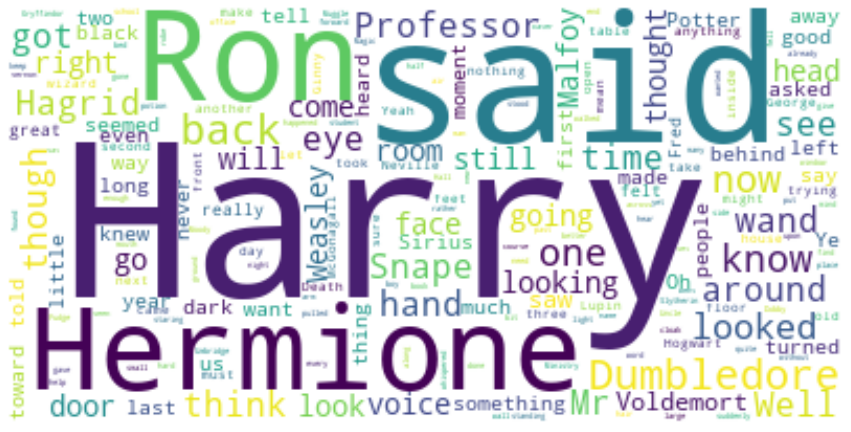

In [9]:
we.generate_wordcloud(we.all_books)

# Word2vec

Let us create and train a Word2Vec embedding model on the preprocessed data. I have experimented with various parameters of the model:

* vector_size
* window_size
* min_word_count
* epochs
* down_sampling

**Observations**:
* vector_size 100 gives good results, they don't improve significantly after increasing it to 256


In [10]:
# Word2Vec paramters
num_feature = 100
min_word_count = 5
window_size = 10
down_sampling = 0.001
iteration = 20
sg=1

# Create Word2Vec model
w2vec_model = we.word2vec_model(book_sentences,  num_feature, min_word_count, 
                  window_size, down_sampling, sg)



2022-06-05 17:00:28,366 : INFO : collecting all words and their counts
2022-06-05 17:00:28,378 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-05 17:00:28,448 : INFO : PROGRESS: at sentence #10000, processed 84155 words, keeping 6437 word types
2022-06-05 17:00:28,478 : INFO : PROGRESS: at sentence #20000, processed 170625 words, keeping 9109 word types
2022-06-05 17:00:28,518 : INFO : PROGRESS: at sentence #30000, processed 240148 words, keeping 10603 word types
2022-06-05 17:00:28,550 : INFO : PROGRESS: at sentence #40000, processed 302503 words, keeping 12003 word types
2022-06-05 17:00:28,580 : INFO : PROGRESS: at sentence #50000, processed 361226 words, keeping 13077 word types
2022-06-05 17:00:28,615 : INFO : PROGRESS: at sentence #60000, processed 446600 words, keeping 14766 word types
2022-06-05 17:00:28,657 : INFO : PROGRESS: at sentence #70000, processed 569522 words, keeping 16492 word types
2022-06-05 17:00:28,662 : INFO : collected 16548 

In [11]:
print("Total number of words: {}".format(len(w2vec_model.wv.key_to_index)))

Total number of words: 6691


## Get Dictionary

In [43]:
# Words are ordered according to decreasing frequency. 
#Top frequency words appear at the top
we.getDictionary(w2vec_model)[:20]

['harry',
 'say',
 'ron',
 'look',
 'hermione',
 'get',
 'go',
 'know',
 'think',
 'back',
 'dumbledore',
 'could',
 'see',
 'one',
 'like',
 'come',
 'tell',
 'would',
 'around',
 'eye']

## Top 10 words with Word2Vec
We order the vocab by most frequent words using sorted_vocab attribute of Word2Vec and retrieve the top 10. We get words like Harry, Ron, Hermione in the top words.

In [13]:
top_words = we.top_10_frequent_words(w2vec_model)
top_words

['harry',
 'say',
 'ron',
 'look',
 'hermione',
 'get',
 'go',
 'know',
 'think',
 'back']

## Most similar words to top 10 words with Word2Vec
We see words like Hermione and Ron are most similar to each other.

In [14]:
we.most_similar_words(w2vec_model, top_words)

Most similar to  harry :  [('ron', 0.7265907526016235), ('silencio', 0.6914387345314026), ('hermione', 0.6812456250190735), ('sceptically', 0.6685629487037659), ('tremulously', 0.6664249897003174), ('options', 0.658836305141449), ('goodnight', 0.6429656147956848), ('tensely', 0.638627290725708), ('exasperatedly', 0.6361172795295715), ('back', 0.6331034898757935)]
Most similar to  say :  [('ask', 0.7165927886962891), ('well', 0.7138505578041077), ('scoff', 0.6681712865829468), ('oh', 0.6663616299629211), ('know', 0.6596862077713013), ('hmmm', 0.6513105630874634), ('yes', 0.6503114104270935), ('harry', 0.6323049664497375), ('think', 0.6315926313400269), ('yeah', 0.6279149055480957)]
Most similar to  ron :  [('hermione', 0.8546380996704102), ('harry', 0.7265907526016235), ('goodnight', 0.6727980375289917), ('scandalize', 0.633036732673645), ('ginny', 0.6240652203559875), ('aaah', 0.6045141220092773), ('george', 0.5981253385543823), ('thunderstruck', 0.5979795455932617), ('infuriate', 0.59

To test the model further, I have checked the similar words to some magic spells from Harry Potter. We see, for _Avada (Avada Kedavra_ spell), most similar is _Kedavra_. Also, for _Hogwarts_, most similar is _School_.

In [15]:
print(w2vec_model.wv.most_similar("avada"))
print(w2vec_model.wv.most_similar("expecto"))
print(w2vec_model.wv.most_similar("lumos"))
print(w2vec_model.wv.most_similar("dumbledore"))
print(w2vec_model.wv.most_similar("hogwarts"))

[('kedavra', 0.9569318890571594), ('expelliarmus', 0.6656011343002319), ('unforgivable', 0.6196795701980591), ('crucio', 0.6014413237571716), ('impedimenta', 0.5960601568222046), ('rebound', 0.578210175037384), ('waitress', 0.5771713256835938), ('whine', 0.5730738639831543), ('stupefy', 0.5638341903686523), ('jet', 0.5617681741714478)]
[('patronum', 0.9717077612876892), ('otter', 0.6616460084915161), ('wisp', 0.605968177318573), ('fog', 0.6028965711593628), ('petrificus', 0.5945016145706177), ('protego', 0.5840536952018738), ('totalus', 0.5772987604141235), ('stag', 0.5599668622016907), ('clammy', 0.5473964810371399), ('aargh', 0.5438020825386047)]
[('ignite', 0.7599468231201172), ('wand', 0.6119696497917175), ('reparo', 0.5890833139419556), ('light', 0.5837756395339966), ('vapour', 0.5604777336120605), ('imperio', 0.5588639378547668), ('arch', 0.5546481013298035), ('tip', 0.5527899861335754), ('alohomora', 0.5438332557678223), ('skyward', 0.5427126288414001)]
[('headmaster', 0.6794047


## Odd word using Word2Vec

In [16]:
word_list = ["Harry","Hermione", "train"] #walle
odd_word = we.odd_word(w2vec_model, word_list)
print("The odd word is ", odd_word)

The odd word is  train


## Visualising Word2Vec Embeddings with TSNE

To avoid overly crowded plot, let us plot top word embedding using TSNE.
We see words like hermione ron are near , mr and weasley are together, dark, voldemort, potter are close.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


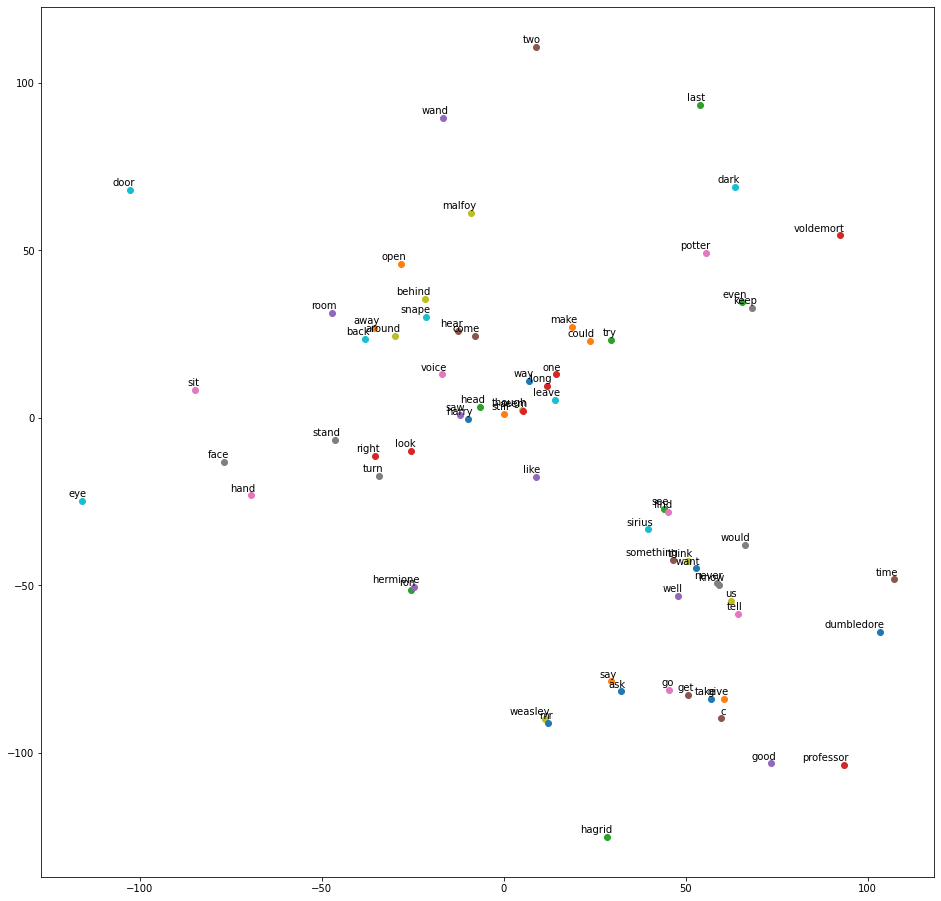

In [31]:
we.plot_tsne(w2vec_model, num_words = 70)

# Fasttext

Let us create and train a FastText embedding model on the preprocessed data. I have experimented with various parameters of the model:

* vector_size
* window_size
* min_word_count
* epochs
* down_sampling

**Observations**:

In [17]:
# Fasttext parameters
num_feature = 100
min_word_count = 5
window_size = 10
down_sampling = 0.001
iteration = 20

# Create a fastext model
model_fastText = we.fasttext_model(book_sentences, num_feature, window_size, 
                                    min_word_count)

2022-06-05 17:01:40,104 : INFO : collecting all words and their counts
2022-06-05 17:01:40,106 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-05 17:01:40,187 : INFO : PROGRESS: at sentence #10000, processed 84155 words, keeping 6437 word types
2022-06-05 17:01:40,213 : INFO : PROGRESS: at sentence #20000, processed 170625 words, keeping 9109 word types
2022-06-05 17:01:40,238 : INFO : PROGRESS: at sentence #30000, processed 240148 words, keeping 10603 word types
2022-06-05 17:01:40,261 : INFO : PROGRESS: at sentence #40000, processed 302503 words, keeping 12003 word types
2022-06-05 17:01:40,285 : INFO : PROGRESS: at sentence #50000, processed 361226 words, keeping 13077 word types
2022-06-05 17:01:40,321 : INFO : PROGRESS: at sentence #60000, processed 446600 words, keeping 14766 word types
2022-06-05 17:01:40,357 : INFO : PROGRESS: at sentence #70000, processed 569522 words, keeping 16492 word types
2022-06-05 17:01:40,362 : INFO : collected 16548 

## Top 10 Words with Fasttext

In [18]:
top_words = we.top_10_frequent_words(model_fastText)
top_words

['harry',
 'say',
 'ron',
 'look',
 'hermione',
 'get',
 'go',
 'know',
 'think',
 'back']

## Most similar words to top 10 words with FastText
We see words like Hermione and Ron are most similar to each other. Similarly _back_ and _aback_, _say_ and _sayin_ are similar to each other.

In [19]:
we.most_similar_words(model_fastText, top_words)

Most similar to  harry :  [('harp', 0.5479258298873901), ('arry', 0.5343486666679382), ('harsh', 0.49138596653938293), ('barry', 0.48100706934928894), ('harshly', 0.47930610179901123), ('hopefully', 0.4710060954093933), ('harper', 0.4606828987598419), ('hardly', 0.4522239863872528), ('harness', 0.4437425136566162), ('hard', 0.4433293044567108)]
Most similar to  say :  [('sayin', 0.7130235433578491), ('ask', 0.6018242239952087), ('oh', 0.5920661091804504), ('ah', 0.5869526267051697), ('aaah', 0.577444314956665), ('sad', 0.5720301866531372), ('sarcasm', 0.5597436428070068), ('aaaah', 0.5479901432991028), ('okay', 0.5233922600746155), ('ooh', 0.521248996257782)]
Most similar to  ron :  [('rons', 0.7233307361602783), ('iron', 0.6739728450775146), ('ronan', 0.6580653786659241), ('baron', 0.6393399238586426), ('moron', 0.61771160364151), ('apron', 0.6166530847549438), ('ginny', 0.5256892442703247), ('crookshanks', 0.4998105764389038), ('ok', 0.4722720682621002), ('seamus', 0.4137252271175384

To test the model further, I have checked the similar words to some magic spells from Harry Potter. We see, for _Avada (Avada Kedavra_ spell), most similar is _Kedavra_. Also, for _Hogwarts_, most similar is _ogwarts_:.

In [20]:
print(model_fastText.wv.most_similar("avada"))
print(model_fastText.wv.most_similar("lumos"))
print(model_fastText.wv.most_similar("expecto"))
print(model_fastText.wv.most_similar("hogwarts"))
print(model_fastText.wv.most_similar("dumbledore"))



[('kedavra', 0.8791778087615967), ('expelliarmus', 0.6212646961212158), ('cruciatus', 0.6167282462120056), ('crucio', 0.6042208671569824), ('curse', 0.5595863461494446), ('bella', 0.5191957354545593), ('bellatrix', 0.5095393657684326), ('killin', 0.5089583396911621), ('whoosh', 0.5022376179695129), ('volkov', 0.4997921288013458)]
[('twirl', 0.54984050989151), ('luminous', 0.5468977093696594), ('glum', 0.5309141278266907), ('wave', 0.5050281286239624), ('patronum', 0.49939408898353577), ('directly', 0.489840567111969), ('flick', 0.4864705502986908), ('tap', 0.48542240262031555), ('raise', 0.481509268283844), ('lumpy', 0.4684904217720032)]
[('expect', 0.7805984616279602), ('unexpected', 0.7061405181884766), ('expel', 0.6880911588668823), ('expelliarmus', 0.6699967980384827), ('expert', 0.6298949718475342), ('expensive', 0.5893750190734863), ('patronum', 0.576850950717926), ('expectantly', 0.5745901465415955), ('explode', 0.5129415392875671), ('explore', 0.49326473474502563)]
[('ogwarts',

##Odd word using Fasttext

In [21]:
word_list = ["Harry","Hermione", "Walle"] #walle
odd_word = we.odd_word(model_fastText, word_list)
print("The odd word is ", odd_word)

The odd word is  walle


## Visualising Fasttext Embeddings with TSNE

To avoid overly crowded plot, let us plot top word embedding using TSNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


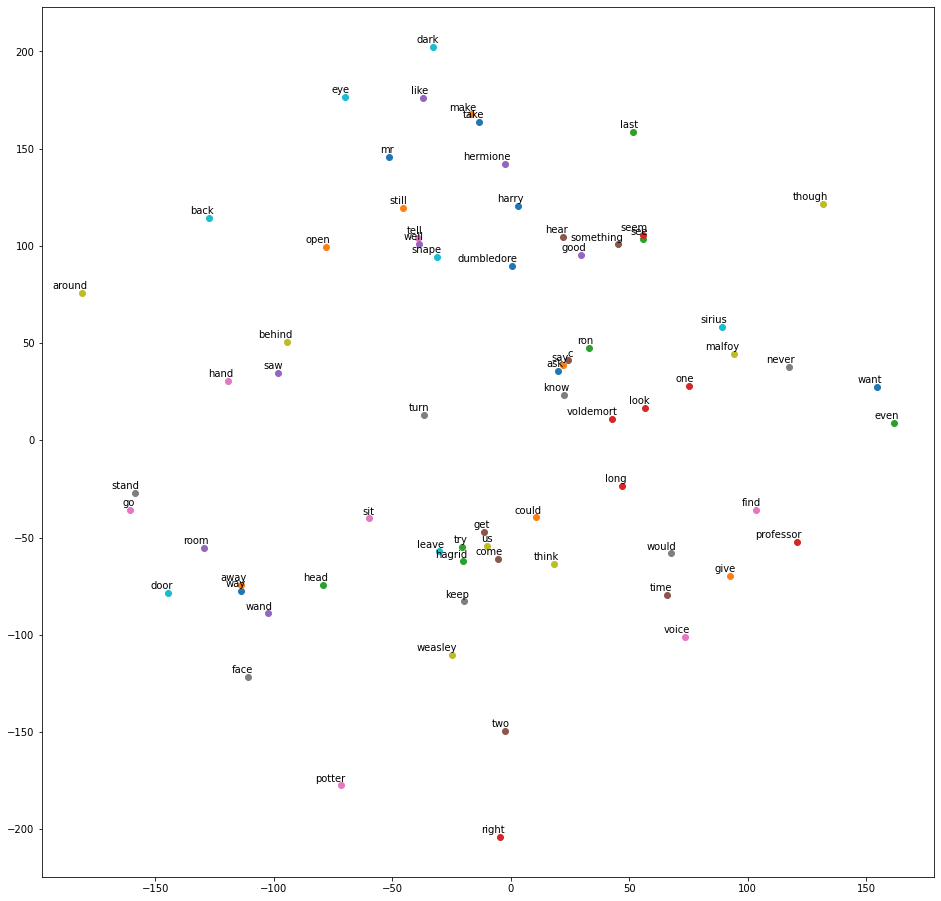

In [32]:
we.plot_tsne(model_fastText, num_words = 70)

# GloVe

Let us create GloVe word embeddings. Since gensim does not provide support for training a GloVe model, I have used glove-python library. I have experimented with various parameters of the model:

* vector_size
* window_size
* epochs


**Observations**:


In [22]:
window_size = 10
num_features = 100
lr = 0.05
iterations = 20

model_glove = we.glove_model(book_sentences, window_size, num_features, lr, iterations)

In [23]:
model_glove.save('glove.model')

### Convert Glove-python model to gensim model
We will convert the glove-python model to a gensim model so we can use gensim model's functionalities. For this, we save the vectors from our trained glove model and treat this saved file as a pretrained model, and load it as a gensim model.

In [24]:
glove_input_file = 'glove_embeddings.txt'
word2vec_output_file = 'word2vec.txt'
gensim_glove_model = we.save_glove_as_gensim(model_glove, glove_input_file, word2vec_output_file)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
2022-06-05 17:03:57,523 : INFO : loading projection weights from glove_embeddings.txt
2022-06-05 17:03:59,215 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (16548, 100) matrix of type float32 from glove_embeddings.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-06-05T17:03:59.215097', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}
2022-06-05 17:03:59,217 : INFO : converting 16548 vectors from glove_embeddings.txt to word2vec.txt
2022-06-05 17:03:59,243 : INFO : storing 16548x100 projection weights into word2vec.txt
2022-06-05 17:04:00,549 : INFO : loading projection weights from word2vec.txt
2022-06-05 17:04:01,681 : I

## Top 10 Words

In [46]:
top_words = we.top_10_frequent_words_2(gensim_glove_model)
top_words

['harry',
 'say',
 'ron',
 'look',
 'hermione',
 'get',
 'go',
 'know',
 'think',
 'back']

## Most similar words to top 10 words with Glove
We see words like Hermione and Ron are most similar to each other.

In [26]:
we.most_similar_words_glove(model_glove, top_words)

Most similar to  harry :  [('recognise', 0.8920242764912691), ('recognize', 0.8851638641138097), ('release', 0.8363621321737874), ('remind', 0.8245594144648682)]
Most similar to  say :  [('scrimgeour', 0.8941209512199478), ('aberforth', 0.8876266859954253), ('excellent', 0.8781842687072056), ('problem', 0.8756643523985984)]
Most similar to  ron :  [('hermione', 0.9437827451933333), ('hopefully', 0.8850852175642495), ('add', 0.8750077890662885), ('together', 0.8740372002441282)]
Most similar to  look :  [('terrify', 0.9172965599649341), ('round', 0.8967215004735645), ('puzzle', 0.8835046630831572), ('startle', 0.8749498444633205)]
Most similar to  hermione :  [('ron', 0.943782745193333), ('whisper', 0.9044214651971448), ('hopefully', 0.8736637894409676), ('gasp', 0.8435217318957172)]
Most similar to  get :  [('manage', 0.9006999948575642), ('better', 0.8866682892507073), ('stuff', 0.8706698880868858), ('rid', 0.8664509672191718)]
Most similar to  go :  [('let', 0.9505328814641893), ('st

To test the model further, I have checked the similar words to some magic spells from Harry Potter. We see, for _Avada (Avada Kedavra_ spell), most similar is _Kedavra_. Also, for _Hogwarts_, most similar is _school_.

In [27]:
print(model_glove.most_similar("avada"))
print(model_glove.most_similar("lumos"))
print(model_glove.most_similar("expecto"))
print(model_glove.most_similar("hogwarts"))
print(model_glove.most_similar("dumbledore"))



[('repel', 0.9817239219921347), ('kedavra', 0.97928894731559), ('seventeenth', 0.9766145368346428), ('mesmerize', 0.9732906002593424)]
[('elder', 0.8595733695982688), ('eyebrows', 0.81342822149693), ('raise', 0.780916413690157), ('flick', 0.771784429367589)]
[('patronum', 0.9829121078998504), ('plummet', 0.9350777276565848), ('engulf', 0.9342034501856955), ('3', 0.925485034964151)]
[('school', 0.9701746813561194), ('champion', 0.8860520652584163), ('students', 0.8423077861482372), ('express', 0.8377899146113961)]
[('albus', 0.9159896877642514), ('headmaster', 0.8310207445492175), ('snape', 0.8212557100238804), ('trust', 0.8096411244208244)]


##Odd word using Glove

In [28]:
word_list = ["Harry","Hermione", "Wand"]
odd_word = we.odd_word_glove(gensim_glove_model, word_list)
print("The odd word is ", odd_word)

The odd word is  harry


## Visualising GloVe Embeddings with TSNE

To avoid overly crowded plot, let us plot top word embedding using TSNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


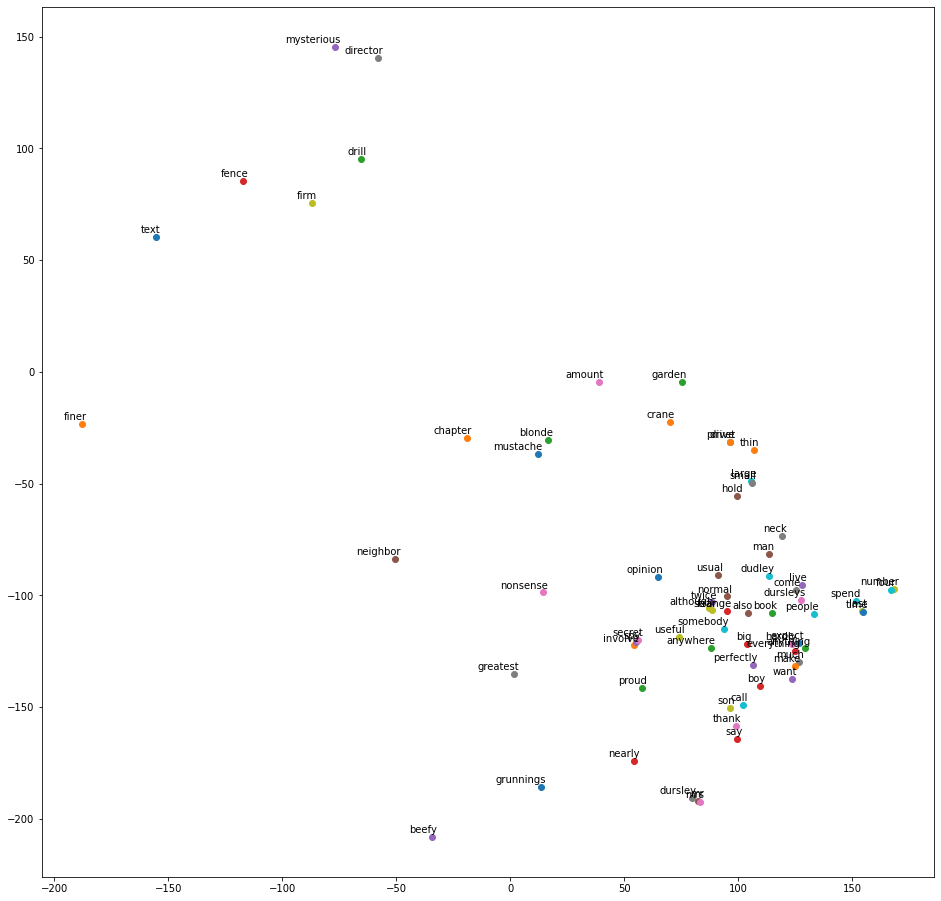

In [33]:
we.plot_tsne_glove(gensim_glove_model, num_words = 70)

# Performance measure comparison and conclusion

We can compare model performance using the similarity metrics and overall results returned by all models.
* Word2Vec:
  * We get very similar words like _Harry:Ron_ (similarity 0.73),
_look:glance_ (similarity 0.61), _ron:hermione_ (similarity 0.84) which indicates a good performance
  * For the other words like magic spells also it has very significant similarity results, where it returns words that are semantically similar to the spells

* Fasttext:
  * We can see it mostly shows similar words as words that have similar spelling. eg. _harry:arry_ (similarity 0.52), _say:sayin (similarity 0.7), _look:overlook_ (similarity 0.74), _back:aback_ (similarity 0.53)
  * The similarity scores are quite lower than Word2Vec
  * The similarities also do not seem very semantic like word2vec, which showed the character names close to each other instead of similar spelling words.
* GloVe:
  * Glove has high similarity for few pairs like _ron:hermione_ (similarity 0.95), but even after changing model parameters, the results do not seem very satisfactory as it returns pairs like _harry:recognise_, _say:scrimgeour_ with high similarity scores (0.91, 0.89)

Based on these metrics and observations, Word2Vec model with 100 vector size seems to perform well with respect to metrics as well as semantics on this harry potter dataset

In [29]:
print("Word2Vec: \n")
we.most_similar_words(w2vec_model, top_words)
print("\nFasttext: \n")
we.most_similar_words(model_fastText, top_words)
print("\nGlove: \n")
we.most_similar_words_glove(model_glove, top_words)

Word2Vec: 

Most similar to  harry :  [('ron', 0.7265907526016235), ('silencio', 0.6914387345314026), ('hermione', 0.6812456250190735), ('sceptically', 0.6685629487037659), ('tremulously', 0.6664249897003174), ('options', 0.658836305141449), ('goodnight', 0.6429656147956848), ('tensely', 0.638627290725708), ('exasperatedly', 0.6361172795295715), ('back', 0.6331034898757935)]
Most similar to  say :  [('ask', 0.7165927886962891), ('well', 0.7138505578041077), ('scoff', 0.6681712865829468), ('oh', 0.6663616299629211), ('know', 0.6596862077713013), ('hmmm', 0.6513105630874634), ('yes', 0.6503114104270935), ('harry', 0.6323049664497375), ('think', 0.6315926313400269), ('yeah', 0.6279149055480957)]
Most similar to  ron :  [('hermione', 0.8546380996704102), ('harry', 0.7265907526016235), ('goodnight', 0.6727980375289917), ('scandalize', 0.633036732673645), ('ginny', 0.6240652203559875), ('aaah', 0.6045141220092773), ('george', 0.5981253385543823), ('thunderstruck', 0.5979795455932617), ('infu

In [30]:
print("Word2Vec Magic Spells: \n")
print("Most similar to Avada: ", w2vec_model.wv.most_similar("avada"))
print("Most similar to expecto: ",w2vec_model.wv.most_similar("expecto"))
print("Most similar to lumos: ",w2vec_model.wv.most_similar("lumos"))
print("Most similar to dumbledore: ",w2vec_model.wv.most_similar("dumbledore"))
print("Most similar to hogwarts: ",w2vec_model.wv.most_similar("hogwarts"))

print("\nFasttext Magic Spells: \n")
print("Most similar to Avada: ",model_fastText.wv.most_similar("avada"))
print("Most similar to lumos: ",model_fastText.wv.most_similar("lumos"))
print("Most similar to expecto: ",model_fastText.wv.most_similar("expecto"))
print("Most similar to hogwarts: ",model_fastText.wv.most_similar("hogwarts"))
print("Most similar to dumbledore: ",model_fastText.wv.most_similar("dumbledore"))

print("\nGlove Magic Spells: \n")
print("Most similar to Avada: ",model_glove.most_similar("avada"))
print("Most similar to lumos: ",model_glove.most_similar("lumos"))
print("Most similar to expecto: ",model_glove.most_similar("expecto"))
print("Most similar to hogwarts: ",model_glove.most_similar("hogwarts"))
print("Most similar to dumbledore: ",model_glove.most_similar("dumbledore"))


Word2Vec Magic Spells: 

Most similar to Avada:  [('kedavra', 0.9569318890571594), ('expelliarmus', 0.6656011343002319), ('unforgivable', 0.6196795701980591), ('crucio', 0.6014413237571716), ('impedimenta', 0.5960601568222046), ('rebound', 0.578210175037384), ('waitress', 0.5771713256835938), ('whine', 0.5730738639831543), ('stupefy', 0.5638341903686523), ('jet', 0.5617681741714478)]
Most similar to expecto:  [('patronum', 0.9717077612876892), ('otter', 0.6616460084915161), ('wisp', 0.605968177318573), ('fog', 0.6028965711593628), ('petrificus', 0.5945016145706177), ('protego', 0.5840536952018738), ('totalus', 0.5772987604141235), ('stag', 0.5599668622016907), ('clammy', 0.5473964810371399), ('aargh', 0.5438020825386047)]
Most similar to lumos:  [('ignite', 0.7599468231201172), ('wand', 0.6119696497917175), ('reparo', 0.5890833139419556), ('light', 0.5837756395339966), ('vapour', 0.5604777336120605), ('imperio', 0.5588639378547668), ('arch', 0.5546481013298035), ('tip', 0.5527899861335

# Convert Notebook to PDF

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!python -m pip install -U notebook-as-pdf
!pyppeteer-install